In [1]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, precision_recall_fscore_support
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Embedding, Add, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


2025-06-08 07:13:53.923319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366834.150814      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366834.219034      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ----- 0. GLOBAL CONSTANTS AND KEYPOINT DEFINITIONS -----
KEYPOINT_NAMES = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
]
SORTED_KEYPOINT_NAMES = sorted(KEYPOINT_NAMES)
KEYPOINT_DICT = {name: i for i, name in enumerate(SORTED_KEYPOINT_NAMES)}
NUM_KEYPOINTS = len(KEYPOINT_DICT)

print("--- Initializing Keypoint Definitions ---")
print(f"SORTED_KEYPOINT_NAMES (used for ordering): {SORTED_KEYPOINT_NAMES}")
print(f"Generated KEYPOINT_DICT: {KEYPOINT_DICT}")
print(f"NUM_KEYPOINTS: {NUM_KEYPOINTS}")
if NUM_KEYPOINTS != 17:
    print(f"WARNING: NUM_KEYPOINTS is {NUM_KEYPOINTS}, expected 17.")
print("----------------------------------------")

--- Initializing Keypoint Definitions ---
SORTED_KEYPOINT_NAMES (used for ordering): ['Left Ankle', 'Left Ear', 'Left Elbow', 'Left Eye', 'Left Hip', 'Left Knee', 'Left Shoulder', 'Left Wrist', 'Nose', 'Right Ankle', 'Right Ear', 'Right Elbow', 'Right Eye', 'Right Hip', 'Right Knee', 'Right Shoulder', 'Right Wrist']
Generated KEYPOINT_DICT: {'Left Ankle': 0, 'Left Ear': 1, 'Left Elbow': 2, 'Left Eye': 3, 'Left Hip': 4, 'Left Knee': 5, 'Left Shoulder': 6, 'Left Wrist': 7, 'Nose': 8, 'Right Ankle': 9, 'Right Ear': 10, 'Right Elbow': 11, 'Right Eye': 12, 'Right Hip': 13, 'Right Knee': 14, 'Right Shoulder': 15, 'Right Wrist': 16}
NUM_KEYPOINTS: 17
----------------------------------------


In [3]:
# ----- 1. HELPER FUNCTION FOR KEYPOINT INDICES -----
def get_kpt_indices(keypoint_name):
    if keypoint_name not in KEYPOINT_DICT:
        available_keys = list(KEYPOINT_DICT.keys())
        similar_keys = [k for k in available_keys if keypoint_name.lower() in k.lower() or k.lower() in keypoint_name.lower()]
        error_msg = f"Keypoint name '{keypoint_name}' not found in KEYPOINT_DICT. "
        error_msg += f"Available keys: {available_keys}. "
        if similar_keys: error_msg += f"Did you mean: {similar_keys}? "
        raise ValueError(error_msg)
    kp_idx = KEYPOINT_DICT[keypoint_name]
    return kp_idx * 3, kp_idx * 3 + 1, kp_idx * 3 + 2

In [4]:
# ----- 2. SKELETON NORMALIZATION FUNCTION -----
def normalize_skeleton(sequence_data, min_confidence=0.3):
    normalized_sequence = np.copy(sequence_data)
    ref_kp_names = {
        'ls': 'Left Shoulder', 'rs': 'Right Shoulder',
        'lh': 'Left Hip', 'rh': 'Right Hip'
    }
    for ref_kp_key, ref_kp_name_val in ref_kp_names.items():
        if ref_kp_name_val not in KEYPOINT_DICT:
            print(f"WARNING in normalize_skeleton: Ref keypoint '{ref_kp_name_val}' not in KEYPOINT_DICT.")

    for t in range(sequence_data.shape[0]):
        frame_data = sequence_data[t, :]
        current_frame_normalized = np.copy(frame_data)
        try:
            ls_x_idx, ls_y_idx, ls_c_idx = get_kpt_indices(ref_kp_names['ls'])
            rs_x_idx, rs_y_idx, rs_c_idx = get_kpt_indices(ref_kp_names['rs'])
            lh_x_idx, lh_y_idx, lh_c_idx = get_kpt_indices(ref_kp_names['lh'])
            rh_x_idx, rh_y_idx, rh_c_idx = get_kpt_indices(ref_kp_names['rh'])
        except ValueError:
            normalized_sequence[t, :] = frame_data; continue

        ls_x, ls_y, ls_c = frame_data[ls_x_idx], frame_data[ls_y_idx], frame_data[ls_c_idx]
        rs_x, rs_y, rs_c = frame_data[rs_x_idx], frame_data[rs_y_idx], frame_data[rs_c_idx]
        lh_x, lh_y, lh_c = frame_data[lh_x_idx], frame_data[lh_y_idx], frame_data[lh_c_idx]
        rh_x, rh_y, rh_c = frame_data[rh_x_idx], frame_data[rh_y_idx], frame_data[rh_c_idx]

        mid_shoulder_x, mid_shoulder_y = np.nan, np.nan
        valid_ls, valid_rs = ls_c > min_confidence, rs_c > min_confidence
        if valid_ls and valid_rs: mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        elif valid_ls: mid_shoulder_x, mid_shoulder_y = ls_x, ls_y
        elif valid_rs: mid_shoulder_x, mid_shoulder_y = rs_x, rs_y

        mid_hip_x, mid_hip_y = np.nan, np.nan
        valid_lh, valid_rh = lh_c > min_confidence, rh_c > min_confidence
        if valid_lh and valid_rh: mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
        elif valid_lh: mid_hip_x, mid_hip_y = lh_x, lh_y
        elif valid_rh: mid_hip_x, mid_hip_y = rh_x, rh_y

        if np.isnan(mid_hip_x) or np.isnan(mid_hip_y):
            normalized_sequence[t, :] = frame_data; continue

        reference_height = np.nan
        if not np.isnan(mid_shoulder_y) and not np.isnan(mid_hip_y):
            reference_height = np.abs(mid_shoulder_y - mid_hip_y)

        perform_scaling = not (np.isnan(reference_height) or reference_height < 1e-5)

        for kp_i in range(NUM_KEYPOINTS):
            x_i_col, y_i_col = kp_i * 3, kp_i * 3 + 1
            current_frame_normalized[x_i_col] -= mid_hip_x
            current_frame_normalized[y_i_col] -= mid_hip_y
            if perform_scaling:
                current_frame_normalized[x_i_col] /= reference_height
                current_frame_normalized[y_i_col] /= reference_height
        normalized_sequence[t, :] = current_frame_normalized
    return normalized_sequence

In [5]:
# ----- 3. DATA LOADING FUNCTION  -----
def load_dataset(data_path, expected_shape_template=(30, None), normalize=True, min_confidence_norm=0.3):
    if NUM_KEYPOINTS is None or NUM_KEYPOINTS == 0:
        raise ValueError("NUM_KEYPOINTS is not set or is zero.")
    expected_shape = (expected_shape_template[0], NUM_KEYPOINTS * 3)
    
    X, y = [], []
    npy_filepaths = []

    print(f"Loading data from: {data_path}, expecting shape {expected_shape} for .npy files.")
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(data_path, label_name)
        if not os.path.isdir(folder):
            print(f"Warning: Subfolder not found for label '{label_name}': {folder}")
            continue
        
        files_in_folder = glob(os.path.join(folder, "*.npy"))
        print(f"Found {len(files_in_folder)} .npy files in {folder}")
        
        loaded_count_for_label = 0
        for file_path_str in files_in_folder:
            try:
                arr = np.load(file_path_str)
            except Exception as e:
                print(f"Warning: Could not load file {file_path_str}: {e}")
                continue

            if arr.shape == expected_shape:
                if normalize:
                    arr_normalized = normalize_skeleton(arr, min_confidence=min_confidence_norm)
                    if np.isnan(arr_normalized).any():
                        arr_normalized = np.nan_to_num(arr_normalized, nan=0.0, posinf=0.0, neginf=0.0)
                    X.append(arr_normalized)
                else:
                    X.append(arr)
                y.append(label_val)
                npy_filepaths.append(file_path_str)
                loaded_count_for_label += 1
            else:
                print(f"Warning: Skipping file {file_path_str} due to incorrect shape: {arr.shape}. Expected: {expected_shape}")
        print(f"Successfully loaded {loaded_count_for_label} samples for label '{label_name}'.")

    if not X:
        print(f"Critical Warning: No data was loaded from {data_path}.")
        return np.array([]), np.array([]), []
        
    return np.array(X), np.array(y), npy_filepaths

In [26]:
# ----- Data Augmentation -----
def augment_sequence(
    seq,
    enable_scaling=False,
    enable_rotation=True,
    enable_translation=True,
    enable_jitter=True,
    enable_confidence_noise=False,
    enable_dropout=False
):
    seq = seq.copy() 
    # --- 1. Scaling: ขยายหรือย่อขนาดโดยรวมของร่างกาย ---
    if enable_scaling:
        scale = np.random.uniform(0.9, 1.1)
        for i in range(17):
            seq[:, i*3]   *= scale
            seq[:, i*3+1] *= scale
    # --- 2. Rotation: หมุน keypoints แต่ละ frame รอบจุดศูนย์กลางของร่างกายในแต่ละเฟรม ---        
    if enable_rotation:
        angle = np.radians(np.random.uniform(-10, 10))
        cos_v, sin_v = np.cos(angle), np.sin(angle)
        for t in range(seq.shape[0]):
            x_coords = seq[t, ::3]
            y_coords = seq[t, 1::3]
            cx, cy = x_coords.mean(), y_coords.mean()
            for i in range(17):
                x = seq[t, i*3]   - cx
                y = seq[t, i*3+1] - cy
                seq[t, i*3]   = x*cos_v - y*sin_v + cx
                seq[t, i*3+1] = x*sin_v + y*cos_v + cy
    # --- 3. Translation: ขยับตำแหน่ง keypoints ไปทางซ้าย/ขวา/บน/ล่าง ---            
    if enable_translation:
        dx, dy = np.random.randint(-20, 21), np.random.randint(-20, 21)
        for i in range(17):
            seq[:, i*3]   += dx
            seq[:, i*3+1] += dy
    if enable_jitter:
        for _ in range(np.random.randint(1, 4)):
            t = np.random.randint(1, seq.shape[0] - 1)
            seq[t] = (seq[t - 1] + seq[t + 1]) / 2
    if enable_confidence_noise:
        seq[:, 2::3] += np.random.normal(0, 0.02, size=seq[:, 2::3].shape)
        seq[:, 2::3] = np.clip(seq[:, 2::3], 0, 1)
    if enable_dropout:
        for _ in range(np.random.randint(1, 4)):
            t = np.random.randint(0, seq.shape[0])
            i = np.random.randint(0, 17)
            seq[t, i*3:i*3+3] = 0
    return seq

In [27]:
# --- Transformer Encoder Block ---
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout_rate=0.1, name_prefix=""):
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout_rate,
        name=f"{name_prefix}_mha"
    )(inputs, inputs, inputs)
    attention_output = Dropout(dropout_rate, name=f"{name_prefix}_mha_dropout")(attention_output)
    out1 = LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_layernorm1")(inputs + attention_output)

    ffn_output = Dense(ff_dim, activation="relu", name=f"{name_prefix}_ffn_dense1")(out1)
    ffn_output = Dense(d_model, name=f"{name_prefix}_ffn_dense2")(ffn_output)
    ffn_output = Dropout(dropout_rate, name=f"{name_prefix}_ffn_dropout")(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_layernorm2")(out1 + ffn_output)
    return out2

# --- Positional Embedding Layer (Learned) ---
def get_positional_embedding(seq_len, d_model, name_prefix=""):
    positions = tf.range(start=0, limit=seq_len, delta=1)
    position_embeddings_2d = Embedding(input_dim=seq_len, output_dim=d_model, name=f"{name_prefix}_pos_embed")(positions)
    position_embeddings_3d = tf.expand_dims(position_embeddings_2d, axis=0)
    return position_embeddings_3d

In [28]:
# --- Model Creation Function ---
def create_transformer_classifier(
    input_shape,
    num_encoder_blocks=2,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    projection_dim=None,
    final_dense_units=32,
    dropout_rate=0.1,
    learning_rate=0.0005
):
    timesteps, num_features = input_shape
    if projection_dim is None: projection_dim = d_model

    inputs = Input(shape=input_shape, name="input_features")
    projected_x = Dense(projection_dim, name="feature_projection")(inputs)
    positional_embeddings = get_positional_embedding(timesteps, projection_dim, name_prefix="pos_enc")
    x = Add(name="add_positional_encoding")([projected_x, positional_embeddings])
    x = Dropout(dropout_rate, name="input_dropout_after_pos_enc")(x)

    for i in range(num_encoder_blocks):
        x = transformer_encoder_block(x, projection_dim, num_heads, ff_dim, dropout_rate, name_prefix=f"encoder_block_{i+1}")

    x = GlobalAveragePooling1D(name="global_avg_pooling")(x)
    x = Dropout(dropout_rate, name="dropout_after_pooling")(x)
    x = Dense(final_dense_units, activation="relu", name="final_dense_1")(x)
    x = Dropout(dropout_rate / 2, name="dropout_final_dense")(x)
    outputs = Dense(1, activation="sigmoid", name="output_sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    f1_macro_metric = tf.keras.metrics.F1Score(
        average='macro', 
        threshold=0.5,
        name='f1_macro'
    )
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_macro_metric])
    return model

In [29]:
#--- Load Dataset ---

# Paths 
base_train = '/kaggle/input/fall-dataset6/train'
base_val   = '/kaggle/input/fall-dataset6/val'
base_test  = '/kaggle/input/fall-dataset6/test'

# ----- Parameters -----
TIMESTEPS = 30
EXPECTED_SHAPE_TEMPLATE = (TIMESTEPS, None)
MIN_CONF_NORM = 0.2

# ----- NEW DATA PREPARATION FLOW: AUGMENT -> NORMALIZE -----

# 1. Load training data WITHOUT normalization to perform augmentation first.
print("\n--- Loading Training Data (Raw, for Augmentation) ---")
X_train_orig, y_train_orig, train_npy_filepaths = load_dataset(
    base_train, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=False, # <-- CHANGED: Load raw data
    min_confidence_norm=MIN_CONF_NORM
)

# 2. Load val and test data WITH normalization as they are not augmented.
print("\n--- Loading Validation Data (with Normalization) ---")
X_val_orig, y_val_orig, val_npy_filepaths = load_dataset(
    base_val, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=True, # <-- UNCHANGED: Val set is normalized directly
    min_confidence_norm=MIN_CONF_NORM
)
print("\n--- Loading Test Data (with Normalization) ---")
X_test_orig, y_test_orig, test_npy_filepaths = load_dataset(
    base_test, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=True, # <-- UNCHANGED: Test set is normalized directly
    min_confidence_norm=MIN_CONF_NORM
)


# 3. Perform augmentation on RAW training data, then normalize the result.
if X_train_orig.size > 0:
    print(f"\n--- Starting Data Preparation for Training Set ---")
    print(f"Initial raw training data shape: {X_train_orig.shape}")
    
    # 3.1 Augment raw data
    print("Step 1: Augmenting raw data...")
    augment_counts = {0: 1, 1: 1}  # no_fall:1, fall:1
    aug_X_raw, aug_y = [], []
    for xi, yi in zip(X_train_orig, y_train_orig):
        count = augment_counts.get(yi, 1)
        for _ in range(count):
            aug_X_raw.append(augment_sequence(xi))
            aug_y.append(yi)
    
    # 3.2 Combine original raw data with augmented raw data
    X_train_augmented_raw = np.concatenate([X_train_orig, np.array(aug_X_raw)], axis=0)
    y_train_augmented = np.concatenate([y_train_orig, np.array(aug_y)], axis=0)
    print(f"Shape after augmentation (before normalization): {X_train_augmented_raw.shape}")
    
    # 3.3 Normalize the entire augmented dataset
    print("Step 2: Normalizing all (original + augmented) training data...")
    X_train_normalized_list = [normalize_skeleton(seq, min_confidence=MIN_CONF_NORM) for seq in X_train_augmented_raw]
    X_train_normalized = np.array(X_train_normalized_list)
    
    # Handle any NaNs that might result from normalization
    if np.isnan(X_train_normalized).any():
        X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0, posinf=0.0, neginf=0.0)
        print("NaNs found in normalized data and were replaced with 0.0.")

    # 3.4 Shuffle the final prepared dataset and assign it back to the original variables
    print("Step 3: Shuffling final prepared data...")
    X_train_orig, y_train_orig = shuffle(X_train_normalized, y_train_augmented, random_state=42)
    print(f"Final prepared training data shape: {X_train_orig.shape}")
    
    # Clean up intermediate variables to save memory
    del X_train_augmented_raw, y_train_augmented, X_train_normalized, X_train_normalized_list, aug_X_raw, aug_y
    
else:
    print("FATAL ERROR: Training data is empty, skipping preparation.")


if X_train_orig.size > 0:
    if len(X_train_orig) > 0: print(f"Prepared Training set: {X_train_orig.shape[0]} samples.")
else: print(f"WARNING: Training set is empty.")

if X_val_orig.size > 0:
    if len(X_val_orig) == len(val_npy_filepaths): print(f"Validation set: Loaded {len(X_val_orig)} samples and filepaths.")
    else: print(f"WARNING: Mismatch in Validation set! Samples: {len(X_val_orig)}, Filepaths: {len(val_npy_filepaths)}.")
else: print("Validation data is empty or was not loaded.")

if X_test_orig.size > 0:
    if len(X_test_orig) == len(test_npy_filepaths): print(f"Test set: Loaded {len(X_test_orig)} samples and filepaths.")
    else: print(f"WARNING: Mismatch in Test set! Samples: {len(X_test_orig)}, Filepaths: {len(test_npy_filepaths)}.")
else: print("Test data is empty or was not loaded.")
    
print(f"\nShapes ready for model:")
print(f"Train: X={X_train_orig.shape if X_train_orig.size > 0 else 'Empty'}, y={y_train_orig.shape if y_train_orig.size > 0 else 'Empty'}")
print(f"Val:   X={X_val_orig.shape if X_val_orig.size > 0 else 'Empty'}, y={y_val_orig.shape if y_val_orig.size > 0 else 'Empty'}")
print(f"Test:  X={X_test_orig.shape if X_test_orig.size > 0 else 'Empty'}, y={y_test_orig.shape if y_test_orig.size > 0 else 'Empty'}")

if 'NUM_KEYPOINTS' in locals() and isinstance(NUM_KEYPOINTS, int) and NUM_KEYPOINTS > 0:
    transformer_input_shape = (TIMESTEPS, NUM_KEYPOINTS * 3)
    print(f"\nTransformer Input Shape: {transformer_input_shape}")
else:
    print("\nERROR: NUM_KEYPOINTS not defined correctly. Cannot determine Transformer Input Shape.")
    transformer_input_shape = (TIMESTEPS, -1)

print("Dataset are loaded!")


--- Loading Training Data (Raw, for Augmentation) ---
Loading data from: /kaggle/input/fall-dataset6/train, expecting shape (30, 51) for .npy files.
Found 6279 .npy files in /kaggle/input/fall-dataset6/train/no_fall
Successfully loaded 6279 samples for label 'no_fall'.
Found 5722 .npy files in /kaggle/input/fall-dataset6/train/fall
Successfully loaded 5722 samples for label 'fall'.

--- Loading Validation Data (with Normalization) ---
Loading data from: /kaggle/input/fall-dataset6/val, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/val/no_fall
Successfully loaded 1346 samples for label 'no_fall'.
Found 1226 .npy files in /kaggle/input/fall-dataset6/val/fall
Successfully loaded 1226 samples for label 'fall'.

--- Loading Test Data (with Normalization) ---
Loading data from: /kaggle/input/fall-dataset6/test, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/test/no_fall
Successfully loaded 1346 sa

In [30]:
# ----- Model Parameters -----
NUM_ENCODER_BLOCKS = 3
D_MODEL = 64
NUM_HEADS = 4
FF_DIM = D_MODEL * 2
PROJECTION_DIM = D_MODEL
FINAL_DENSE_UNITS = 32
DROPOUT_RATE = 0.06
LEARNING_RATE = 0.0001

In [31]:
# ----- Cross-Validation -----
N_SPLITS_CV = 5
EPOCHS_CV = 80
BATCH_SIZE_CV = 32
cv_accuracies, cv_losses, cv_f1_macros = [], [], []
fold_no = 1

print(f"\n--- Starting {N_SPLITS_CV}-Fold Cross-Validation with Transformer Classifier ---")
if X_train_orig.shape[0] > 0 and y_train_orig.shape[0] >= N_SPLITS_CV:
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X_train_orig, y_train_orig):
        print(f"--- Fold {fold_no}/{N_SPLITS_CV} ---")
        X_cv_train, X_cv_val = X_train_orig[train_idx], X_train_orig[val_idx]
        y_cv_train_1d, y_cv_val_1d = y_train_orig[train_idx], y_train_orig[val_idx]

        y_cv_train_2d = y_cv_train_1d.reshape(-1, 1)
        y_cv_val_2d = y_cv_val_1d.reshape(-1, 1)
        
        cv_model = create_transformer_classifier(
            input_shape=transformer_input_shape, num_encoder_blocks=NUM_ENCODER_BLOCKS,
            d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM,
            projection_dim=PROJECTION_DIM, final_dense_units=FINAL_DENSE_UNITS,
            dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE
        )
        
        early_stopping_cv = EarlyStopping(monitor='val_f1_macro', patience=10, verbose=1, mode='max', restore_best_weights=True)
        
        history_cv = cv_model.fit(X_cv_train, y_cv_train_2d,
                                  epochs=EPOCHS_CV, batch_size=BATCH_SIZE_CV, 
                                  validation_data=(X_cv_val, y_cv_val_2d),
                                  callbacks=[early_stopping_cv],
                                  verbose=1) 
        
        eval_results_cv = cv_model.evaluate(X_cv_val, y_cv_val_2d, verbose=0)
        loss, accuracy, f1_macro = eval_results_cv[0], eval_results_cv[1], eval_results_cv[2]

        print(f"Fold {fold_no} - CV Val Loss: {loss:.4f}, CV Val Acc: {accuracy:.4f}, CV Val F1-Macro: {f1_macro:.4f}")
        cv_losses.append(loss); cv_accuracies.append(accuracy); cv_f1_macros.append(f1_macro)
        fold_no += 1

    if cv_accuracies:
        print("\n--- Cross-Validation Summary ---")
        mean_loss = np.mean(cv_losses)
        std_loss = np.std(cv_losses)
        mean_accuracy = np.mean(cv_accuracies)
        std_accuracy = np.std(cv_accuracies)
        
        print(f"Average CV Loss: {mean_loss:.4f} (+/- {std_loss:.4f})")
        print(f"Average CV Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")
        
        if cv_f1_macros:
             mean_f1_macro = np.mean(cv_f1_macros)
             std_f1_macro = np.std(cv_f1_macros)
             print(f"Average CV F1-Macro: {mean_f1_macro:.4f} (+/- {std_f1_macro:.4f})")
    else: 
        print("Cross-validation did not produce results (or was skipped), so no summary plot will be generated.")
else:
    print(f"Skipping CV: Training data empty or too few samples for {N_SPLITS_CV} splits.")


--- Starting 5-Fold Cross-Validation with Transformer Classifier ---
--- Fold 1/5 ---
Epoch 1/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.7239 - f1_macro: 0.6971 - loss: 0.5378 - val_accuracy: 0.8369 - val_f1_macro: 0.8292 - val_loss: 0.3835
Epoch 2/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8263 - f1_macro: 0.8213 - loss: 0.4021 - val_accuracy: 0.8575 - val_f1_macro: 0.8526 - val_loss: 0.3426
Epoch 3/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8483 - f1_macro: 0.8428 - loss: 0.3612 - val_accuracy: 0.8650 - val_f1_macro: 0.8606 - val_loss: 0.3364
Epoch 4/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8553 - f1_macro: 0.8533 - loss: 0.3510 - val_accuracy: 0.8723 - val_f1_macro: 0.8704 - val_loss: 0.3185
Epoch 5/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8658 - f1_macro: 0.8630 - loss: 0.3333 - val_accuracy: 0.8750 - val_f1_macro: 0.8711 - val_loss: 0.3170
Epoch 6/80
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accurac

In [32]:
# ----- Train Final Model -----
BATCH_SIZE_FINAL = 32
EPOCHS_FINAL_NEW = 80
PATIENCE_FINAL_NEW = 15
history_final = None 

INITIAL_LR_FINAL = 0.0001
END_LR_FINAL = 0.00005

if X_train_orig.shape[0] > 0:
    y_train_orig_2d = y_train_orig.reshape(-1, 1)
    y_val_orig_2d = None
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        y_val_orig_2d = y_val_orig.reshape(-1, 1)

    print("\n--- Training Final Model with Transformer Classifier ---")
    
    final_model = create_transformer_classifier(
        input_shape=transformer_input_shape, num_encoder_blocks=NUM_ENCODER_BLOCKS,
        d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM,
        projection_dim=PROJECTION_DIM, final_dense_units=FINAL_DENSE_UNITS,
        dropout_rate=DROPOUT_RATE,
        learning_rate=0.0005
    )

    num_train_samples_final = X_train_orig.shape[0]
    total_decay_steps_final = (num_train_samples_final // BATCH_SIZE_FINAL) * EPOCHS_FINAL_NEW 
    
    final_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=INITIAL_LR_FINAL,
        decay_steps=total_decay_steps_final,
        end_learning_rate=END_LR_FINAL,
        power=0.5
    )
    
    optimizer_with_schedule_final = Adam(learning_rate=final_lr_schedule)

    f1_metric_for_recompile = tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_macro')
    final_model.compile(optimizer=optimizer_with_schedule_final,
                        loss='binary_crossentropy',
                        metrics=['accuracy', f1_metric_for_recompile])
    print(f"Recompiled final_model with PolynomialDecay LR schedule (Initial: {INITIAL_LR_FINAL}, End: {END_LR_FINAL}).")

    callbacks_final = []
    validation_data_for_fit = None
    if y_val_orig_2d is not None:
        validation_data_for_fit = (X_val_orig, y_val_orig_2d)
        early_stopping_final = EarlyStopping(
            monitor='val_f1_macro', 
            patience=PATIENCE_FINAL_NEW,
            verbose=1, 
            mode='max', 
            restore_best_weights=True
        )
        callbacks_final.append(early_stopping_final)
        
        class PrintLR(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                current_lr_value = self.model.optimizer.learning_rate
                if isinstance(current_lr_value, tf.keras.optimizers.schedules.LearningRateSchedule):
                    current_lr_value = current_lr_value(self.model.optimizer.iterations)
                try:
                    current_lr_value = tf.keras.backend.get_value(current_lr_value)
                except: pass
                print(f" - LR: {current_lr_value:.7f}", end="")
        callbacks_final.append(PrintLR())

        print(f"Training final model with validation data, LR schedule, and EarlyStopping (patience={PATIENCE_FINAL_NEW}).")
    else:
        print("Training final model without validation data. EarlyStopping on val_f1_macro disabled.")
    
    history_final = final_model.fit(X_train_orig, y_train_orig_2d, 
                                    epochs=EPOCHS_FINAL_NEW,
                                    batch_size=BATCH_SIZE_FINAL, 
                                    validation_data=validation_data_for_fit, 
                                    callbacks=callbacks_final if callbacks_final else None, 
                                    verbose=1)
    
    if final_model:
        if X_test_orig.shape[0] > 0 and y_test_orig.shape[0] > 0:
            y_test_orig_2d = y_test_orig.reshape(-1, 1)
            print("\n--- Evaluating on Test Set (after final training) ---")
            eval_results_final = final_model.evaluate(X_test_orig, y_test_orig_2d, verbose=0)
            test_loss, test_accuracy, test_f1_macro = eval_results_final[0], eval_results_final[1], eval_results_final[2]
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Macro: {test_f1_macro:.4f}")
        else:
            print("Skipping evaluation on Test Set: Test data is empty or not provided.")
else:
    print("Final model was not trained (likely due to empty training data).")


# ----- Export Model and Convert to TFLite -----
if 'final_model' in locals() and isinstance(final_model, tf.keras.Model):
    print("\n--- Evaluating on Test Set (Before Export) ---")
    if 'X_test_orig' in locals() and 'y_test_orig' in locals() and X_test_orig.size > 0:
        y_test_orig_2d_export = y_test_orig.reshape(-1, 1)
        eval_results_export = final_model.evaluate(X_test_orig, y_test_orig_2d_export, verbose=0)
        test_loss_exp, test_acc_exp, test_f1_exp = eval_results_export[0], eval_results_export[1], eval_results_export[2]
        print(f"Test Loss: {test_loss_exp:.4f}, Test Acc: {test_acc_exp:.4f}, Test F1-Macro: {test_f1_exp:.4f}")
    else:
        print("Test data not found or empty for pre-export evaluation.")

    export_directory = 'fall_model_exported_sm'
    try:
        final_model.export(export_directory)
        print(f"Model exported successfully in SavedModel format at: ./{export_directory}")

        print("\nConverting exported SavedModel to TensorFlow Lite...")
        try:
            converter = tf.lite.TFLiteConverter.from_saved_model(export_directory)
            tflite_model_content = converter.convert()
            tflite_model_path = 'fall_detection_transformer.tflite'
            with open(tflite_model_path, 'wb') as f: f.write(tflite_model_content)
            print(f"Model converted to TFLite and saved as {tflite_model_path} ({len(tflite_model_content)/1024:.2f} KB)")
        except Exception as tflite_e:
            print(f"Error during TFLite conversion: {tflite_e}")
    except Exception as e:
        print(f"Error during model export: {e}")
else:
    print("ERROR: 'final_model' not defined or not a Keras Model. Skipping export and TFLite conversion.")



--- Training Final Model with Transformer Classifier ---
Recompiled final_model with PolynomialDecay LR schedule (Initial: 0.0001, End: 5e-05).
Training final model with validation data, LR schedule, and EarlyStopping (patience=15).
Epoch 1/80
751/751 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.7307 - f1_macro: 0.7113 - loss: 0.5344 - val_accuracy: 0.8468 - val_f1_macro: 0.8397 - val_loss: 0.3679
Epoch 2/80
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8397 - f1_macro: 0.8361 - loss: 0.3845 - val_accuracy: 0.8628 - val_f1_macro: 0.8535 - val_loss: 0.3377
Epoch 3/80
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8600 - f1_macro: 0.8556 - loss: 0.3434 - val_accuracy: 0.8822 - val_f1_macro: 0.8768 - val_loss: 0.3023
Epoch 4/80
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8670 - f1_macro: 0.8661 - loss: 0.3295 - val_accuracy: 0.8896 - val_f1_macro: 0.8859 - val_loss: 0.2952
Epoch 5/80
751/751 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8667 - f1_macro: 0

W0000 00:00:1749375296.541200      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749375296.541238      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


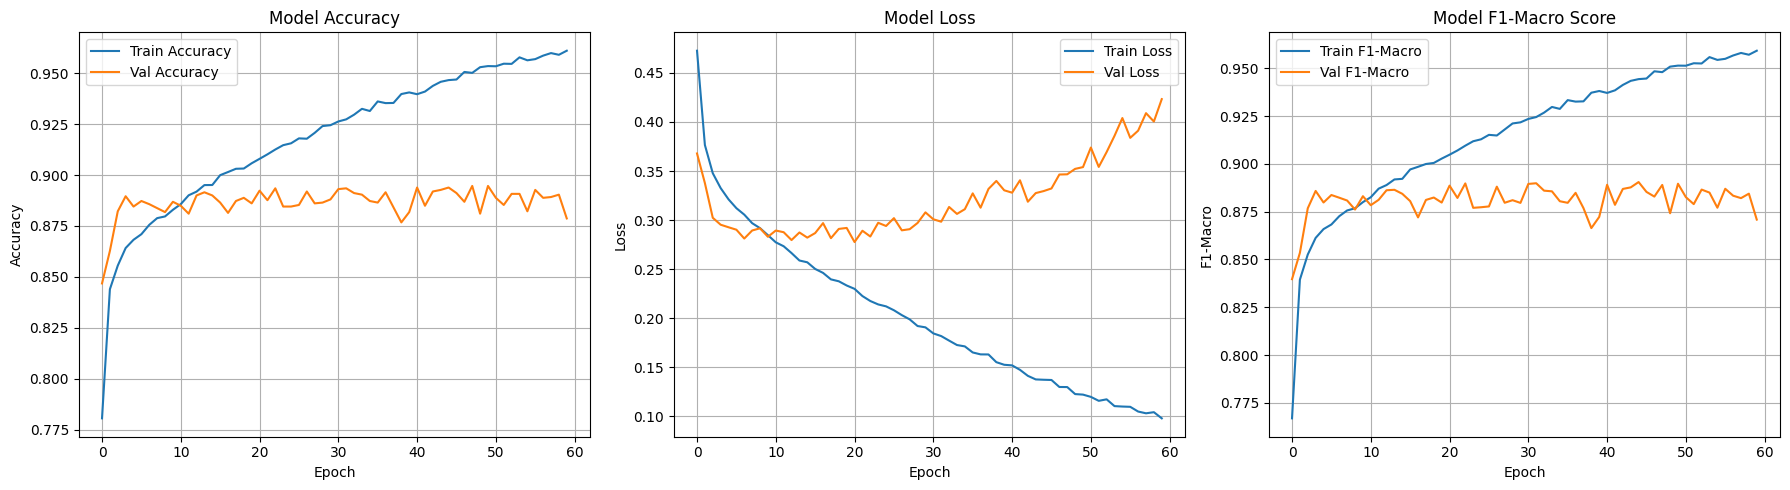

In [33]:
# ----- Plot Training History of Final Model -----
if history_final and hasattr(history_final, 'history') and history_final.history:
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    if 'accuracy' in history_final.history: plt.plot(history_final.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history_final.history: plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 3, 2)
    if 'loss' in history_final.history: plt.plot(history_final.history['loss'], label='Train Loss')
    if 'val_loss' in history_final.history: plt.plot(history_final.history['val_loss'], label='Val Loss')
    plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    if 'f1_macro' in history_final.history: plt.plot(history_final.history['f1_macro'], label='Train F1-Macro')
    if 'val_f1_macro' in history_final.history: plt.plot(history_final.history['val_f1_macro'], label='Val F1-Macro')
    plt.title('Model F1-Macro Score'); plt.xlabel('Epoch'); plt.ylabel('F1-Macro'); plt.legend(); plt.grid(True)
    
    plt.tight_layout(); plt.show()
else:
    print("Skipping plotting: final model training history unavailable.")



--- Custom Validation Metrics Report (Threshold: 0.5) ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9111     0.8834     0.8970     0.8888       1346
fall          0.8761     0.9054     0.8905     0.8994       1226


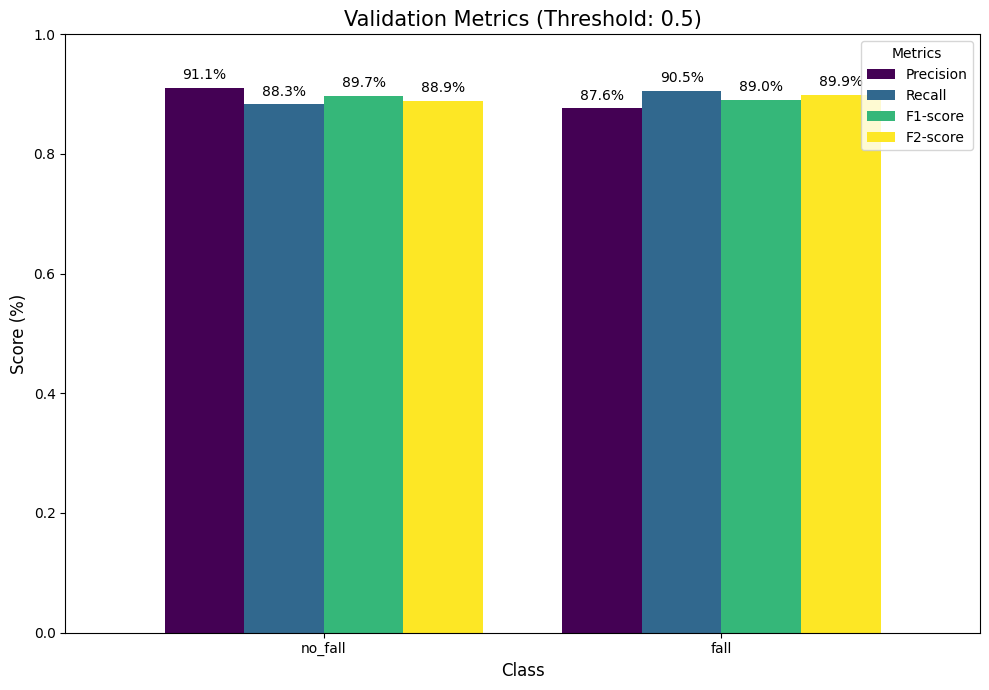

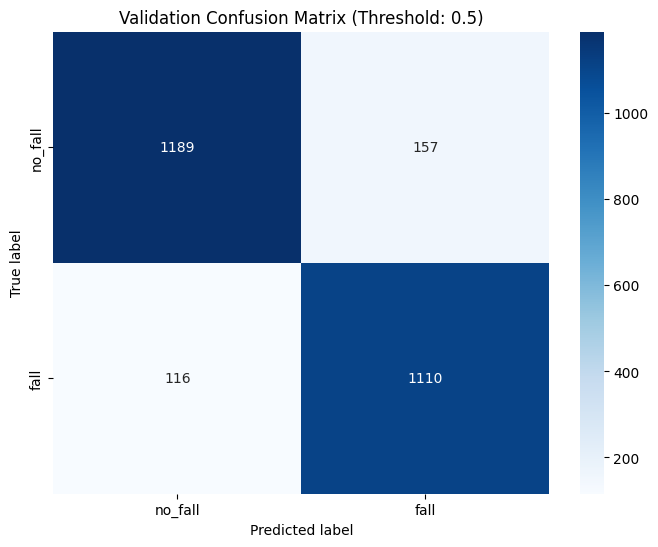



--- Custom Test Metrics Report (Threshold: 0.5) ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9085     0.8997     0.9041     0.9014       1346
fall          0.8910     0.9005     0.8957     0.8986       1226


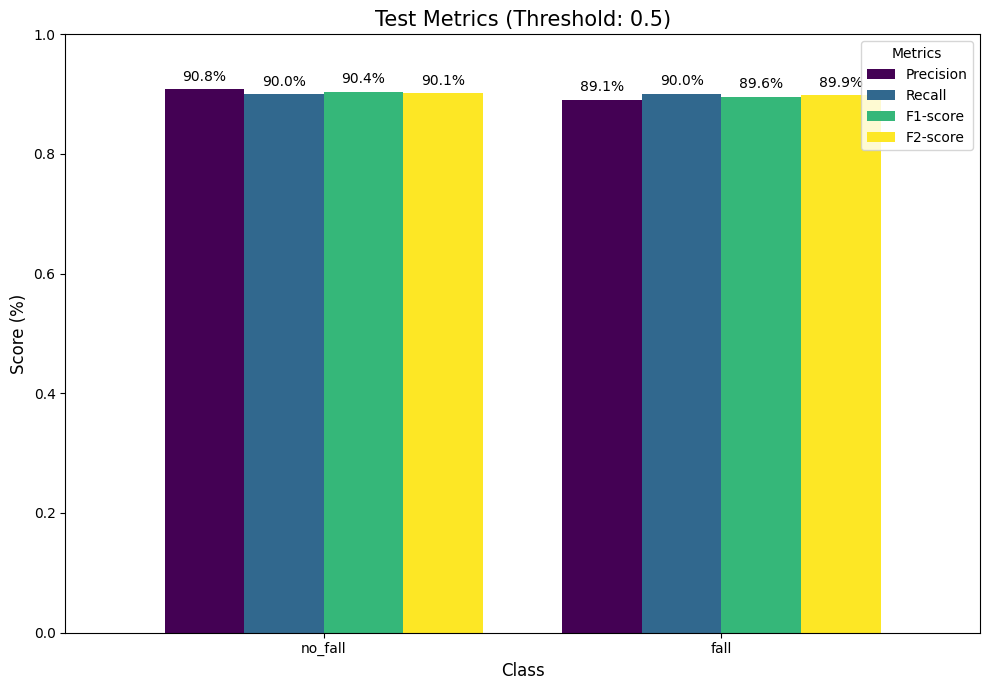

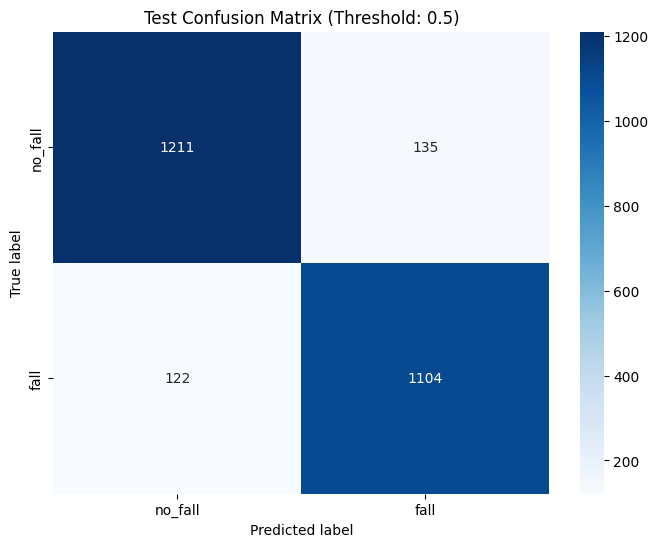

In [51]:
# ----- FUNCTION TO PLOT CONFUSION MATRIX -----
def plot_confusion_matrix_custom(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.show()

# ----- FUNCTION TO PLOT METRICS BARCHART  -----
def plot_metrics_barchart(metrics_data, class_names, title='Metrics per Class'):
    df_metrics = pd.DataFrame(metrics_data, index=class_names)
    ax = df_metrics.plot(kind='bar', figsize=(10, 7), width=0.8, colormap='viridis')
    plt.title(title, fontsize=15); plt.ylabel('Score (%)', fontsize=12); plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=0); plt.ylim(0, 1)
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
    plt.legend(title='Metrics'); plt.tight_layout(); plt.show()

# ----- DETAILED EVALUATION AND REPORTING -----
target_names = ['no_fall', 'fall']
class_labels = [0, 1]

y_pred_val_probs = None
y_pred_val_classes = None
y_pred_test_probs = None
y_pred_test_classes = None

OPTIMIZED_THRESHOLD = 0.5

if final_model is not None:
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        print(f"\n\n--- Custom Validation Metrics Report (Threshold: {OPTIMIZED_THRESHOLD}) ---")
        y_pred_val_probs = final_model.predict(X_val_orig)
        y_pred_val_classes = (y_pred_val_probs > OPTIMIZED_THRESHOLD).astype(int).flatten()
        
        precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
            y_val_orig, y_pred_val_classes, labels=class_labels, zero_division=0
        )
        f2_val_per_class = fbeta_score(y_val_orig, y_pred_val_classes, beta=2, labels=class_labels, average=None, zero_division=0)
        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_val[i]:>10.4f} {recall_val[i]:>10.4f} {f1_val[i]:>10.4f} {f2_val_per_class[i]:>10.4f} {support_val[i]:>10}")
        val_metrics_for_plot = {'Precision': precision_val, 'Recall': recall_val, 'F1-score': f1_val, 'F2-score': f2_val_per_class}
        plot_metrics_barchart(val_metrics_for_plot, target_names, title=f'Validation Metrics (Threshold: {OPTIMIZED_THRESHOLD})')
        cm_val = confusion_matrix(y_val_orig, y_pred_val_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_val, classes=target_names, title=f'Validation Confusion Matrix (Threshold: {OPTIMIZED_THRESHOLD})')

    else: print("\nValidation data empty. Skipping detailed validation metrics report.")

    if X_test_orig.size > 0 and y_test_orig.size > 0:
        print(f"\n\n--- Custom Test Metrics Report (Threshold: {OPTIMIZED_THRESHOLD}) ---")
        y_pred_test_probs = final_model.predict(X_test_orig)
        y_pred_test_classes = (y_pred_test_probs > OPTIMIZED_THRESHOLD).astype(int).flatten()
        
        precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
            y_test_orig, y_pred_test_classes, labels=class_labels, zero_division=0
        )
        f2_test_per_class = fbeta_score(y_test_orig, y_pred_test_classes, beta=2, labels=class_labels, average=None, zero_division=0)
        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_test[i]:>10.4f} {recall_test[i]:>10.4f} {f1_test[i]:>10.4f} {f2_test_per_class[i]:>10.4f} {support_test[i]:>10}")
        test_metrics_for_plot = {'Precision': precision_test, 'Recall': recall_test, 'F1-score': f1_test, 'F2-score': f2_test_per_class}
        plot_metrics_barchart(test_metrics_for_plot, target_names, title=f'Test Metrics (Threshold: {OPTIMIZED_THRESHOLD})')
        cm_test = confusion_matrix(y_test_orig, y_pred_test_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_test, classes=target_names, title=f'Test Confusion Matrix (Threshold: {OPTIMIZED_THRESHOLD})')
    else: print("\nTest data empty. Skipping detailed test metrics.")
else:
    print("Final model not trained. Skipping detailed evaluation.")
    

In [35]:
# Best threshold on validation set
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0.0
thresholds = np.arange(0.1, 0.9, 0.01)
if y_pred_val_probs is not None:
    for thresh in thresholds:
        current_preds = (y_pred_val_probs > thresh).astype(int)
        current_f1 = f1_score(y_val_orig, current_preds, average='macro')
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = thresh
    print(f"Best threshold on validation set: {best_threshold:.2f} with F1-Macro: {best_f1:.4f}")
else:
    print("Could not find best threshold: y_pred_val_probs is not available.")


Best threshold on validation set: 0.56 with F1-Macro: 0.8956


In [52]:
# ----- Error Analysis and Logging to CSV -----
import numpy as np
import pandas as pd
from pathlib import Path
import csv


print("\nStarting Error Analysis and Logging to CSV...")
csv_error_log_filename = "error_analysis_report.csv"

target_names_map_global = {
    0: 'no_fall',
    1: 'fall'
}

def log_errors_to_csv_list(data_set_name, y_true, y_pred_classes, y_pred_probs, filepaths, target_names_dict, csv_rows_list):
    if not isinstance(target_names_dict, dict):
        print(f"ERROR in log_errors_to_csv_list: target_names_dict for {data_set_name} is not a dictionary. Skipping.")
        return False

    if not (y_true is not None and y_pred_classes is not None and y_pred_probs is not None and filepaths is not None and
            y_true.size > 0 and len(filepaths) > 0 and y_pred_classes.size > 0 and y_pred_probs.size > 0 and
            len(y_true) == len(filepaths) == len(y_pred_classes) == y_pred_probs.shape[0]):
        print(f"Warning: Data for {data_set_name} error analysis is incomplete or mismatched. Skipping {data_set_name} set.")
        return False

    fp_indices = np.where((y_pred_classes == 1) & (y_true == 0))[0]
    fn_indices = np.where((y_pred_classes == 0) & (y_true == 1))[0]

    print(f"\n--- Analyzing {data_set_name} Set ---")
    print(f"Total {data_set_name} Samples: {len(y_true)}")
    print(f"False Positives (No_Fall predicted as Fall): {len(fp_indices)}")
    print(f"False Negatives (Fall predicted as No_Fall): {len(fn_indices)}")

    for fp_idx in fp_indices:
        true_label_int = int(y_true[fp_idx])
        pred_label_int = int(y_pred_classes[fp_idx])
        
        pred_prob_fall = y_pred_probs[fp_idx]
        if isinstance(pred_prob_fall, (np.ndarray, list)):
            pred_prob_fall = pred_prob_fall[0] if len(pred_prob_fall) == 1 else (pred_prob_fall[1] if len(pred_prob_fall) > 1 and pred_label_int == 1 else pred_prob_fall[pred_label_int])


        npy_full_path_str = filepaths[fp_idx]
        npy_filename = Path(npy_full_path_str).name
        
        csv_rows_list.append({
            'File Name': npy_filename,
            'True': target_names_dict.get(true_label_int, str(true_label_int)),
            'Pred': target_names_dict.get(pred_label_int, str(pred_label_int)),
            'Prob': f"{pred_prob_fall:.4f}",
            'Type': 'FP',
            'Set': data_set_name
        })

    for fn_idx in fn_indices:
        true_label_int = int(y_true[fn_idx])
        pred_label_int = int(y_pred_classes[fn_idx])
        
        pred_prob_fall = y_pred_probs[fn_idx]
        if isinstance(pred_prob_fall, (np.ndarray, list)):
            pred_prob_fall = pred_prob_fall[0]

        npy_full_path_str = filepaths[fn_idx]
        npy_filename = Path(npy_full_path_str).name
        
        csv_rows_list.append({
            'File Name': npy_filename,
            'True': target_names_dict.get(true_label_int, str(true_label_int)),
            'Pred': target_names_dict.get(pred_label_int, str(pred_label_int)),
            'Prob': f"{pred_prob_fall:.4f}",
            'Type': 'FN',
            'Set': data_set_name
        })
    return True


# --- Main CSV Logging Logic ---
all_error_rows = []

print(f"Using target names map: {target_names_map_global}")

val_analyzed_success = False
if 'y_val_orig' in locals() and 'y_pred_val_classes' in locals() and \
   'y_pred_val_probs' in locals() and 'val_npy_filepaths' in locals():
    print("Proceeding with Validation Set Error Analysis...")
    val_analyzed_success = log_errors_to_csv_list(
        data_set_name='val',
        y_true=np.array(y_val_orig).flatten(),
        y_pred_classes=np.array(y_pred_val_classes).flatten(),
        y_pred_probs=np.array(y_pred_val_probs).flatten(),
        filepaths=val_npy_filepaths,
        target_names_dict=target_names_map_global,
        csv_rows_list=all_error_rows
    )
else:
    print("Skipping Validation Set Error Analysis: One or more required variables are missing "
          "(y_val_orig, y_pred_val_classes, y_pred_val_probs, val_npy_filepaths).")

test_analyzed_success = False
if 'y_test_orig' in locals() and 'y_pred_test_classes' in locals() and \
   'y_pred_test_probs' in locals() and 'test_npy_filepaths' in locals():
    print("Proceeding with Test Set Error Analysis...")
    test_analyzed_success = log_errors_to_csv_list(
        data_set_name='test',
        y_true=np.array(y_test_orig).flatten(),
        y_pred_classes=np.array(y_pred_test_classes).flatten(),
        y_pred_probs=np.array(y_pred_test_probs).flatten(),
        filepaths=test_npy_filepaths,
        target_names_dict=target_names_map_global,
        csv_rows_list=all_error_rows
    )
else:
    print("Skipping Test Set Error Analysis: One or more required variables are missing "
          "(y_test_orig, y_pred_test_classes, y_pred_test_probs, test_npy_filepaths).")

if all_error_rows:
    fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
    
    with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, row_dict in enumerate(all_error_rows):
            row_dict_with_index = {'#': i + 1, **row_dict}
            writer.writerow(row_dict_with_index)
    print(f"\nError Analysis Report (CSV) saved to: {csv_error_log_filename}")
elif not val_analyzed_success and not test_analyzed_success:
    fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
    with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerow({'#': '', 'File Name': 'No data available for analysis or required variables missing.',
                         'True': '', 'Pred': '', 'Prob': '', 'Type': '', 'Set': ''})
    print(f"Empty Error Analysis Report (CSV) created at: {csv_error_log_filename} (No data for analysis).")
else:
    if not all_error_rows and (val_analyzed_success or test_analyzed_success):
        fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
        with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerow({'#': '', 'File Name': 'No False Positives or False Negatives found in the analyzed set(s).',
                             'True': '', 'Pred': '', 'Prob': '', 'Type': '', 'Set': ''})
        print(f"\nError Analysis Report (CSV) indicates no FP/FN found: {csv_error_log_filename}")


Starting Error Analysis and Logging to CSV...
Using target names map: {0: 'no_fall', 1: 'fall'}
Proceeding with Validation Set Error Analysis...

--- Analyzing val Set ---
Total val Samples: 2572
False Positives (No_Fall predicted as Fall): 157
False Negatives (Fall predicted as No_Fall): 116
Proceeding with Test Set Error Analysis...

--- Analyzing test Set ---
Total test Samples: 2572
False Positives (No_Fall predicted as Fall): 135
False Negatives (Fall predicted as No_Fall): 122

Error Analysis Report (CSV) saved to: error_analysis_report.csv
